In [4]:
import boto3
import json
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
%pip install KModes
from kmodes.kmodes import KModes

Note: you may need to restart the kernel to use updated packages.


In [5]:
from sagemaker import get_execution_role
import sagemaker
sagemaker_session = sagemaker.Session()
role = get_execution_role()

conn = boto3.client('s3')
contents = conn.list_objects(Bucket='ad440-mpg-floop-export-storage')['Contents']
for f in contents:
    print(f['Key'])

auto-floop-s3-export3.json
enriched-conv-1k-sagemaker.json
enriched-conv-1k.json
enriched-conv-sample.json


In [3]:
dataset = conn.get_object(Bucket = 'ad440-mpg-floop-export-storage', Key = 'enriched-conv-1k-sagemaker.json')['Body'].read()
data = pd.read_json(dataset)

In [6]:
# Initiate s3 connection to desired bucket and desired object filename.
s3 = boto3.resource('s3')

obj = s3.Object('ad440-mpg-floop-export-storage',
                'enriched-conv-1k-sagemaker.json')

# Loads body of json from the s3 object
# global data
data = json.load(obj.get()['Body'])
path = 's3://ad440-mpg-floop-export-storage/enriched-conv-1k-sagemaker.json'
# data = pd.read_json(obj).values.tolist()

In [7]:
print(data[0])


[{'Text': 'Eleborate and Write conclusion   3marks', 'uid': 'T', 'metadata': ['statement', 'neutral', 'hard to read']}]


In [8]:
attrArray = []
for thread in data:
    for convItem in thread:
        attrArray.append(convItem['metadata'])
print(attrArray[0:3])

[['statement', 'neutral', 'hard to read'], ['Unknown', 'neutral', 'hard to read'], ['sentence', 'neutral', 'hard to read']]


In [9]:
convProp = [{"type": str(item[0]), "sentiment": str(
    item[1]), "emotion": str(item[2])} for item in attrArray]
df = pd.DataFrame(convProp)
print(convProp[0:3])
df.info()

[{'type': 'statement', 'sentiment': 'neutral', 'emotion': 'hard to read'}, {'type': 'Unknown', 'sentiment': 'neutral', 'emotion': 'hard to read'}, {'type': 'sentence', 'sentiment': 'neutral', 'emotion': 'hard to read'}]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   type       1099 non-null   object
 1   sentiment  1099 non-null   object
 2   emotion    1099 non-null   object
dtypes: object(3)
memory usage: 25.9+ KB


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 1724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 1724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 1724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 1724.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 112, cost: 1016.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 119, cost: 1551.0
Run 2, iteration: 2/100, moves: 10, cost: 1551.0
Init: initializing centroids


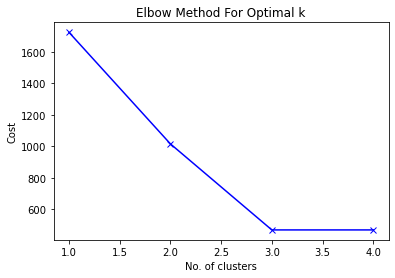

In [13]:
# Elbow curve to find optimal K
cost = []
K = range(1, 5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init="random", n_init=5, verbose=1)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)

plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [10]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=3, init="random", n_init=5, verbose=1)
clusters = kmode.fit_predict(df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 356, cost: 470.0
Run 1, iteration: 2/100, moves: 90, cost: 470.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 743.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 352, cost: 470.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 871.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 704.0
Best run was number 1


array([0, 2, 1, ..., 1, 1, 2], dtype=uint16)

In [11]:
# insert cluster information into the DataFrame
df.insert(0, "Cluster", clusters, True)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Cluster    1099 non-null   uint16
 1   type       1099 non-null   object
 2   sentiment  1099 non-null   object
 3   emotion    1099 non-null   object
dtypes: object(3), uint16(1)
memory usage: 28.0+ KB


,Cluster,type,sentiment,emotion
0,0,statement,neutral,hard to read
1,2,Unknown,neutral,hard to read
2,1,sentence,neutral,hard to read
3,1,sentence,neutral,hard to read
4,2,Unknown,neutral,hard to read
...,...,...,...,...
1094,0,statement,positive,hard to read
1095,2,Unknown,neutral,hard to read
1096,1,sentence,neutral,hard to read
1097,1,sentence,neutral,hard to read


In [12]:
list_col = ['Cluster']
cols = [col for col in df if col not in list_col]
index = ['First Cluster', 'Second Cluster', 'Third Cluster']
df_mod = pd.DataFrame(kmode.cluster_centroids_, columns=cols, index=index)
df_mod

,type,sentiment,emotion
First Cluster,statement,neutral,hard to read
Second Cluster,sentence,neutral,hard to read
Third Cluster,Unknown,neutral,hard to read
